In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pims

import trackpy as tp
from IPython import display
%matplotlib inline

mpl.rc('figure',  figsize=(10, 10))

# Video analysis for supplementary Information
C = 0: green channel, HK. Generally less populated than
C = 1: red channel, Ald.

We are going to look at all videos and try to match particles and their trajectories.

The null hypothesis is that the trajectories are not correlated. What is the probability of observing the given data, if this is true?

## Step 1: locating the particles

We are going to look at individual frames to spot the particles and calibrate the parameters

In [142]:
# loading the video data
frames_0 = pims.TiffStack_libtiff("../stackdata_3/hk with ald 2_c_0.tif")
frames_1 = pims.TiffStack_libtiff("../stackdata_3/hk with ald 2_c_1.tif")

In [162]:
# our parameters
minmass = 120 # 60 for most, 150 for 20x objective
minsize = 5
separation = 20

In [163]:
# locating the particles
f_0 = tp.locate(frames_0[0], minsize, minmass = minmass, separation = separation)
f_1 = tp.locate(frames_1[0], minsize, minmass = minmass, separation=separation)

In [164]:
f_0

,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,426.016393,30.978142,127.045049,1.218707,0.345874,20.688210,484.0,0.133696,0
1,482.139607,120.262668,134.265095,1.255803,0.281471,19.438587,527.0,0.110914,0
2,388.306620,130.096167,199.245514,1.268762,0.269171,29.157880,575.0,0.093188,0
3,480.971429,342.260829,150.649047,1.233182,0.148826,23.326304,535.0,0.107505,0
4,475.195389,375.158501,240.899628,1.245164,0.235908,35.405997,697.0,0.066269,0


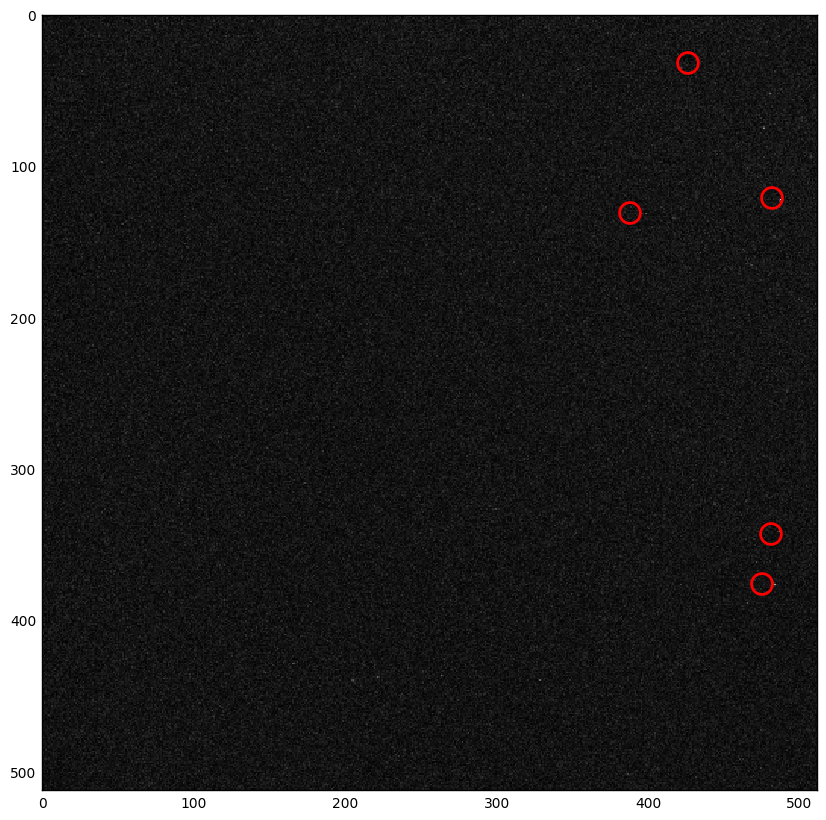

In [165]:
# looking at the first frame from Hexokinase
tp.annotate(f_0[f_0['frame'] == 0], frames_0[1]);

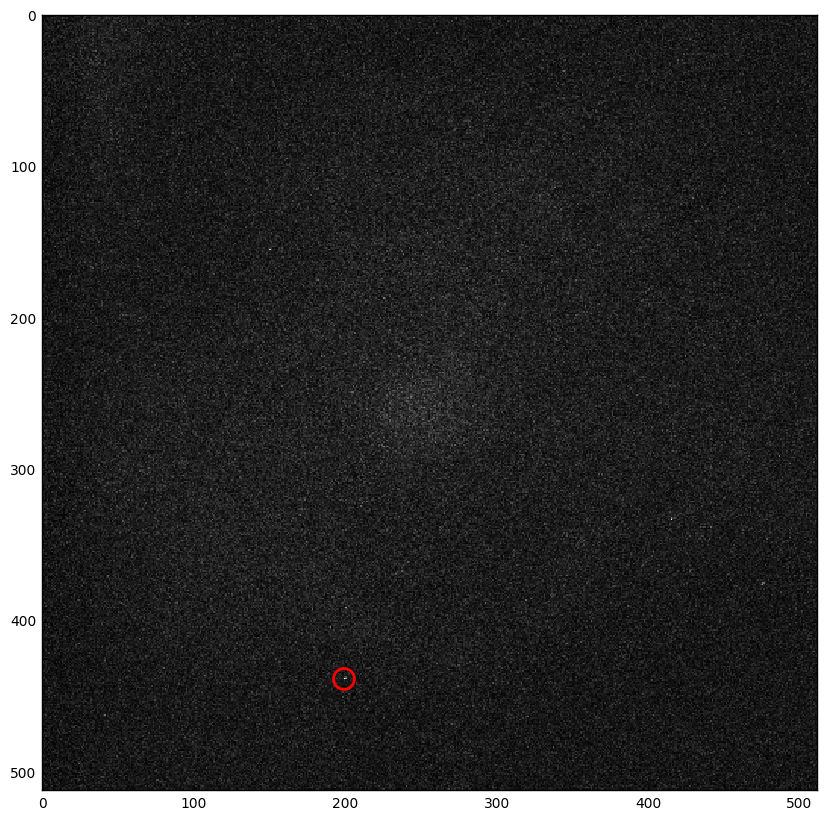

In [166]:
# looking at the first frame from Aldolase
tp.annotate(f_1, frames_1[0]);

The results look good for this frame, now let's run this for the video.

In [167]:
f_0 = tp.batch(frames_0, minsize, minmass=minmass, separation=separation)

Frame 216: 1 features


In [168]:
f_1 = tp.batch(frames_1, minsize, minmass=minmass, separation=separation)

Frame 216: 1 features


## Building trajectories
Same as before, we need to check the parameters to evaluate valid trajectories.

In [169]:
skiphop = 10 # this is the numner of pixels a particle can jump between frames
mem = 5 # this is the number of frames that a particle can 'disappear' for
stubsize = 10 # the minium number of frames a trajectory has to exist for the trajectory to be considered

In [170]:
# now we create the trajectories
t_0 = tp.link_df(f_0, skiphop, memory = mem)
t_1 = tp.link_df(f_1, skiphop, memory = mem)

Frame 216: 1 trajectories present


In [171]:
tl_0 = tp.filter_stubs(t_0, stubsize)
tl_1 = tp.filter_stubs(t_1, stubsize)

In [172]:
tl_0['particle'].unique()

array([ 105.,  180.])

In [173]:
# first let's see how many trajectories we are going to have to watch
traj_parts = [i for i in set(tl_0.particle) if len(tl_0[tl_0.particle ==i]) > 10]
len(traj_parts)

1

### Showing this in graph form
We're happy that it works, now we show this using little graphs that can be put in the suppl!

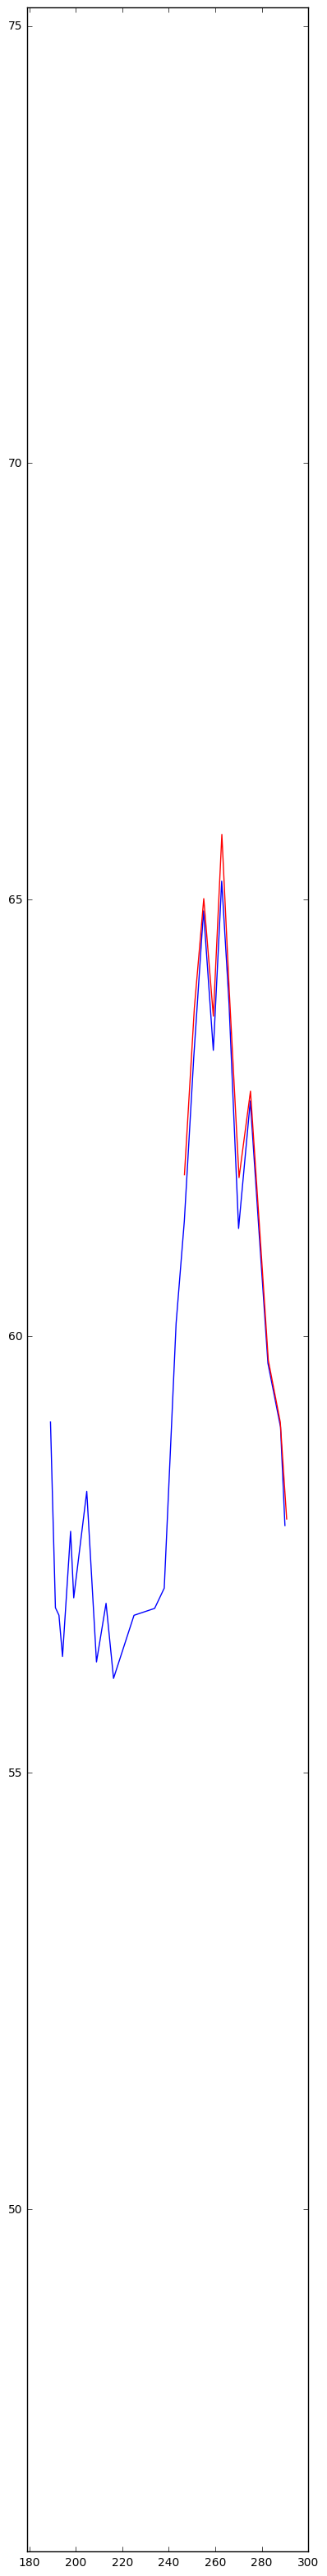

In [174]:
nplots = len(traj_parts)

nrows = int(nplots/3) +1
ncols = 3
buff = 10 # 10 for all but 2 for 2x
plt.figure(figsize=(15,40))
for j, part in enumerate(traj_parts):
    ax = plt.subplot(nrows, ncols, j+1)
    x_traj = tl_0[tl_0.particle == part].x
    y_traj = tl_0[tl_0.particle == part].y
    xlims = [np.min(x_traj)-buff, np.max(x_traj)+buff]
    
    ylims = [np.min(y_traj)-buff, np.max(y_traj)+buff]
    framelims = [tl_0[tl_0.particle ==part].iloc[1].frame,
                 tl_0[tl_0.particle ==part].iloc[-1].frame]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.plot(x_traj, y_traj)
    # candidates
    cands = tl_1[(tl_1.frame >= framelims[0]) &
               (tl_1.frame <= framelims[1]) &
               (tl_1.x >= xlims[0]) &
               (tl_1.x <= xlims[1]) &
               (tl_1.y >= ylims[0]) &
               (tl_1.y <= ylims[1])]
    
    for candidate_particle in set(cands.particle):
        cand = cands[cands.particle == candidate_particle]
        ax.plot(cand.x, cand.y, color='red')

plt.savefig("../img/june_data_1.png")
        

# Plotting the size distribution

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.hist(f_0['mass'], bins=20);
# this is the appearance at t = 0

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
# this is the average appearance over the trajectory
tp.mass_size(tl_0.groupby('particle').mean());

## Iterating over the videos to build a DF.

In [23]:
import os

In [70]:
# getting a list of all the base filenames
root_filenames = []

for filename in os.listdir("../stackdata_2/"):
    if not filename.endswith("C=2.tif"):
        root_filenames.append(filename.split('_c')[0])
        
root_filenames = set(root_filenames)

print root_filenames

set(['control_series1', 'control_series2', 'series1'])


In [71]:
# now for each filename, we load a pair of videos
# and run them through everything
aggregate_df = pd.DataFrame()

for root_filename in list(root_filenames):
    print "working on file: " + root_filename + "\n"
    # load files
    frames_0 = pims.TiffStack_libtiff("../stackdata_2/" + root_filename + "_c0.tif")
    frames_1 = pims.TiffStack_libtiff("../stackdata_2/" + root_filename + "_c1.tif")
    
    # setting the parameters
    if "20X" in root_filename:
        minmass = 150
        minsize = 5
        separation = 20
        buff = 2
    else:
        minmass = 60
        minsize = 5
        separation = 20
        buff = 10 # 10 for all but 2 for 2x
    
    # locating the features
    f_0 = tp.batch(frames_0, minsize, minmass=minmass, separation=separation)
    f_1 = tp.batch(frames_1, minsize, minmass=minmass, separation=separation)

    skiphop = 10 # this is the numner of pixels a particle can jump between frames
    mem = 5 # this is the number of frames that a particle can 'disappear' for
    stubsize = 10 # the minium number of frames a trajectory has to exist for the trajectory to be consideredoO

    # linking trajectories
    t_0 = tp.link_df(f_0, skiphop, memory = mem)
    t_1 = tp.link_df(f_1, skiphop, memory = mem)

    tl_0 = tp.filter_stubs(t_0, stubsize)
    tl_1 = tp.filter_stubs(t_1, stubsize)

    # number of trajectories in the frame of interest
    traj_parts = [i for i in set(tl_0.particle) if len(tl_0[tl_0.particle ==i]) > 10]
    
    n_traj = len(traj_parts)
    
    for j, part in enumerate(traj_parts):
        # our main dataframe
        df_0 = tl_0[tl_0.particle == part]
        # this is our 'main' trajectory
        x_traj = df_0.x
        y_traj = df_0.y
        
        # this is the frame around our trajectory
        xlims = [np.min(x_traj)-buff, np.max(x_traj)+buff]
        ylims = [np.min(y_traj)-buff, np.max(y_traj)+buff]
        framelims = [df_0.iloc[1].frame,
                     df_0.iloc[-1].frame]
        
        # candidate data frame
        cands = tl_1[(tl_1.frame >= framelims[0]) &
                   (tl_1.frame <= framelims[1]) &
                   (tl_1.x >= xlims[0]) &
                   (tl_1.x <= xlims[1]) &
                   (tl_1.y >= ylims[0]) &
                   (tl_1.y <= ylims[1])]
        
        # now we find the longest candidate trajectory
        length_traj = 0
        chosen_particle = None
        for candidate_particle in set(cands.particle):
            cand = cands[cands.particle == candidate_particle]
            if len(cand) > length_traj:
                chosen_particle = candidate_particle
                length_traj = len(cand)
                
        df_1 = cands[cands.particle == chosen_particle]
        
        # now we add some name fields and concatenate the things
        df_0['filename'] = root_filename
        df_1['filename'] = root_filename
        df_0['channel'] = 0
        df_1['channel'] = 1
        df_0['pair_id'] = j
        df_1['pair_id'] = j
        
        aggregate_df = pd.concat([aggregate_df, df_0, df_1])
        
            


Frame 616: 4 trajectories present


In [72]:
aggregate_df.to_csv("../data/trajectory_df_no_iso.csv")

In [73]:
list(root_filenames)[4:5]
testname = list(set(aggregate_df.filename))[0]
testname

'control_series1'

In [74]:
ha = aggregate_df[aggregate_df.filename == testname] 
ha_0 = ha[ha.channel ==0]
ha_1 = ha[ha.channel == 1]

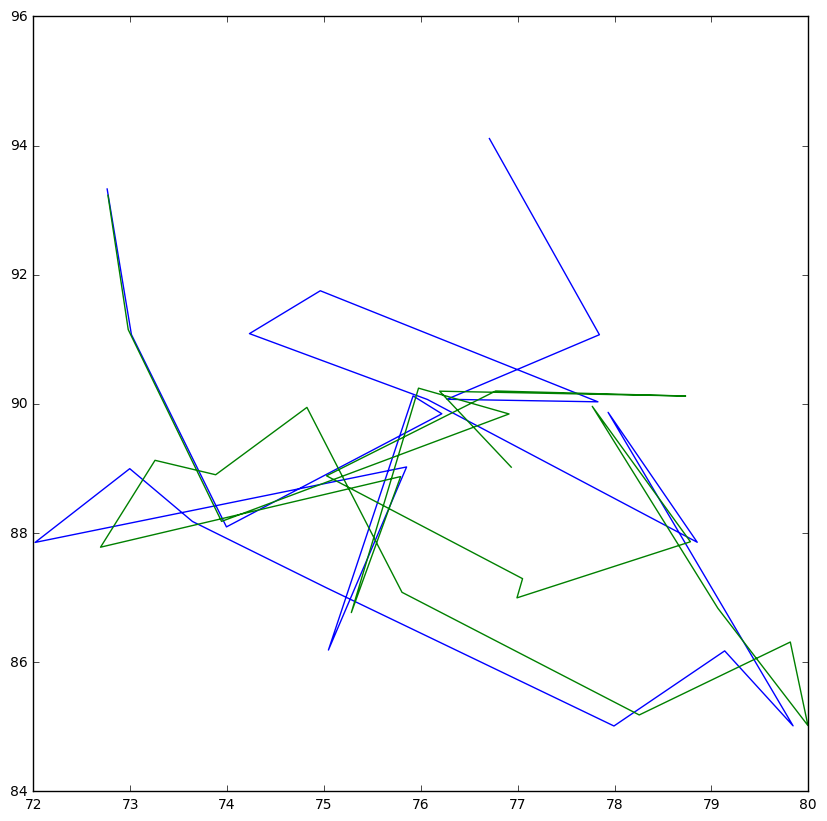

In [75]:
pair_id = 0
test_0 = ha_0[ha_0.pair_id == pair_id]
test_1 = ha_1[ha_1.pair_id == pair_id]
fig, ax = plt.subplots()
ax.plot(test_0.x, test_0.y)
ax.plot(test_1.x, test_1.y)

### Mass distribution plot

In [14]:
df = pd.read_csv("../data/trajectory_df.csv")

In [15]:
df

,frame,x,y,mass,size,ecc,signal,raw_mass,ep,frame.1,particle,filename,channel,pair_id
0,0,147.987699,394.814123,390.272998,1.338241,0.161100,45.339232,834.0,0.018379,0,1.0,with glucose 4 but have flow,0,0
1,1,147.145463,394.810306,377.290372,1.336123,0.150105,43.870973,802.0,0.019165,1,1.0,with glucose 4 but have flow,0,0
2,2,147.939850,392.941176,355.235955,1.347758,0.158641,40.064206,760.0,0.020292,2,1.0,with glucose 4 but have flow,0,0
3,3,146.183499,391.101944,484.570025,1.325606,0.175380,58.589548,972.0,0.014640,3,1.0,with glucose 4 but have flow,0,0
4,4,144.936982,389.914594,435.093711,1.367110,0.206684,45.998713,929.0,0.015708,4,1.0,with glucose 4 but have flow,0,0
5,5,145.156388,389.129956,282.333592,1.353084,0.127515,31.715888,646.0,0.025425,5,1.0,with glucose 4 but have flow,0,0
6,6,145.881776,388.868224,342.742732,1.365975,0.149352,36.676676,767.0,0.019596,6,1.0,with glucose 4 but have flow,0,0
7,7,144.060208,388.101856,238.498476,1.391301,0.159639,23.428777,570.0,0.029145,7,1.0,with glucose 4 but have flow,0,0
8,8,143.827181,387.888032,293.005086,1.377301,0.072873,30.310871,674.0,0.023636,8,1.0,with glucose 4 but have flow,0,0
9,9,142.033679,385.007772,289.661416,1.359734,0.101466,31.892772,675.0,0.023438,9,1.0,with glucose 4 but have flow,0,0


In [16]:
set(df.filename)

{'l-glu',
 'no glucose',
 'with glucose 2',
 'with glucose 3',
 'with glucose 4 but have flow',
 'with glucose 5',
 'with glucose with 20X objective'}

In [17]:
def pos_or_neg(x):
    if x.startswith('with glucose'):
        return 1
    else:
        return 0

In [18]:
df['pos_or_neg'] = df['filename'].apply(pos_or_neg)

In [19]:
df

,frame,x,y,mass,size,ecc,signal,raw_mass,ep,frame.1,particle,filename,channel,pair_id,pos_or_neg
0,0,147.987699,394.814123,390.272998,1.338241,0.161100,45.339232,834.0,0.018379,0,1.0,with glucose 4 but have flow,0,0,1
1,1,147.145463,394.810306,377.290372,1.336123,0.150105,43.870973,802.0,0.019165,1,1.0,with glucose 4 but have flow,0,0,1
2,2,147.939850,392.941176,355.235955,1.347758,0.158641,40.064206,760.0,0.020292,2,1.0,with glucose 4 but have flow,0,0,1
3,3,146.183499,391.101944,484.570025,1.325606,0.175380,58.589548,972.0,0.014640,3,1.0,with glucose 4 but have flow,0,0,1
4,4,144.936982,389.914594,435.093711,1.367110,0.206684,45.998713,929.0,0.015708,4,1.0,with glucose 4 but have flow,0,0,1
5,5,145.156388,389.129956,282.333592,1.353084,0.127515,31.715888,646.0,0.025425,5,1.0,with glucose 4 but have flow,0,0,1
6,6,145.881776,388.868224,342.742732,1.365975,0.149352,36.676676,767.0,0.019596,6,1.0,with glucose 4 but have flow,0,0,1
7,7,144.060208,388.101856,238.498476,1.391301,0.159639,23.428777,570.0,0.029145,7,1.0,with glucose 4 but have flow,0,0,1
8,8,143.827181,387.888032,293.005086,1.377301,0.072873,30.310871,674.0,0.023636,8,1.0,with glucose 4 but have flow,0,0,1
9,9,142.033679,385.007772,289.661416,1.359734,0.101466,31.892772,675.0,0.023438,9,1.0,with glucose 4 but have flow,0,0,1


In [20]:
df['uniqueid'] = df["filename"] + df["pair_id"].map(str) + df['channel'].map(str)

In [21]:
df2 = df.groupby('uniqueid').mean()

In [22]:
df2.index

Index([u'l-glu00', u'no glucose00', u'no glucose01', u'with glucose 200',
       u'with glucose 201', u'with glucose 210', u'with glucose 2100',
       u'with glucose 211', u'with glucose 2110', u'with glucose 2111',
       ...
       u'with glucose with 20X objective50',
       u'with glucose with 20X objective51',
       u'with glucose with 20X objective60',
       u'with glucose with 20X objective61',
       u'with glucose with 20X objective70',
       u'with glucose with 20X objective71',
       u'with glucose with 20X objective80',
       u'with glucose with 20X objective81',
       u'with glucose with 20X objective90',
       u'with glucose with 20X objective91'],
      dtype='object', name=u'uniqueid', length=103)

In [23]:
df2['new_index'] = df2.index.str[:-1]

In [24]:
df3 = df2.pivot(values = 'mass', index = 'new_index', columns = 'channel').dropna()

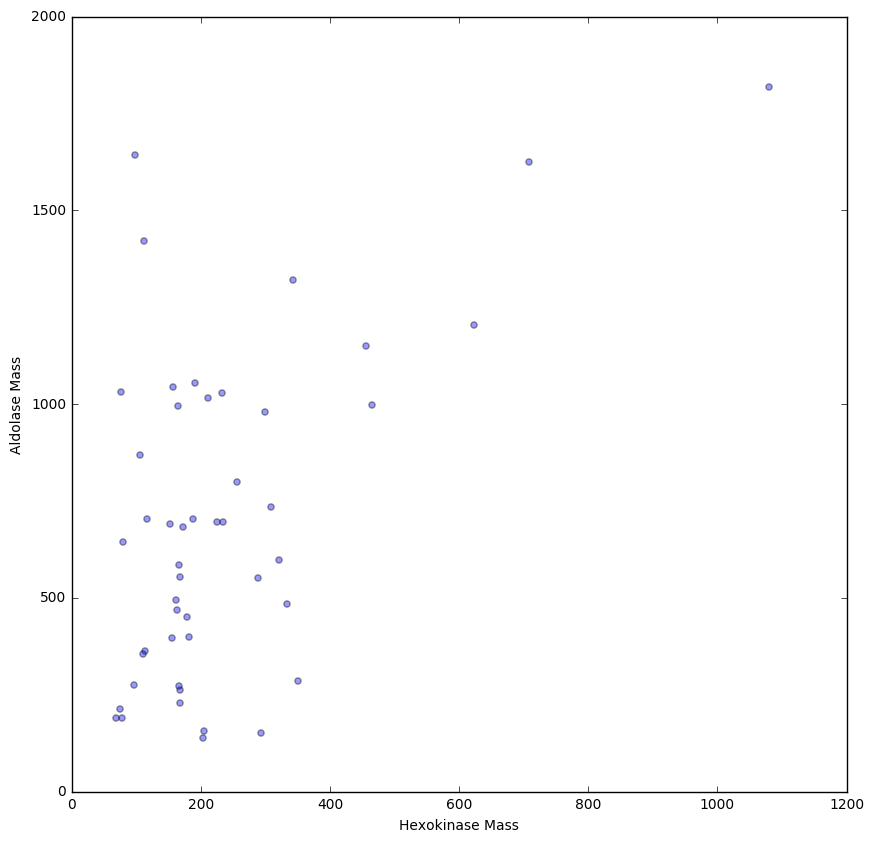

In [25]:
plt.scatter(df3[0], df3[1], alpha = .4)
plt.xlabel('Hexokinase Mass')
plt.ylabel('Aldolase Mass')
#plt.xlim([60,120])
#plt.ylim([0,750])

## Counting Particles

First we need to rebuild a dataframe containing all Aldolase trajectories...

In [ ]:
df = pd.DataFrame()

for root_filename in list(root_filenames):
    print "working on file: " + root_filename + "\n"
    # load files
    frames_0 = pims.TiffStack("../stackdata/" + root_filename + " - C=0.tif")
    frames_1 = pims.TiffStack("../stackdata/" + root_filename + " - C=1.tif")
    
    # setting the parameters
    if "20X" in root_filename:
        minmass = 150
        minsize = 5
        separation = 20
        buff = 2
    else:
        minmass = 60
        minsize = 5
        separation = 20
        buff = 10 # 10 for all but 2 for 2x
    
    # locating the features
    f_0 = tp.batch(frames_0, minsize, minmass=minmass, separation=separation)
    f_1 = tp.batch(frames_1, minsize, minmass=minmass, separation=separation)

    skiphop = 10 # this is the numner of pixels a particle can jump between frames
    mem = 5 # this is the number of frames that a particle can 'disappear' for
    stubsize = 10 # the minium number of frames a trajectory has to exist for the trajectory to be consideredoO

    # linking trajectories
    t_0 = tp.link_df(f_0, skiphop, memory = mem)
    t_1 = tp.link_df(f_1, skiphop, memory = mem)

    tl_0 = tp.filter_stubs(t_0, stubsize)
    tl_1 = tp.filter_stubs(t_1, stubsize)

    tl_0['filename'] = root_filename
    tl_1['filename'] = root_filename
    tl_0['channel'] = 0
    tl_1['channel'] = 1

    df = pd.concat([df, tl_0, tl_1])

In [26]:
ha = df.groupby(['channel', 'filename'])['particle'].unique()

In [27]:
traj_count_0 = [len(set(elem)) for elem in ha[0]]
traj_count_1 = [len(set(elem)) for elem in ha[1]]

In [28]:
dict(zip(ha[0].index, traj_count_0))

{'l-glu': 1,
 'no glucose': 1,
 'with glucose 2': 12,
 'with glucose 3': 2,
 'with glucose 4 but have flow': 20,
 'with glucose 5': 1,
 'with glucose with 20X objective': 18}

In [29]:
dict(zip(ha[1].index, traj_count_1))

{'no glucose': 1,
 'with glucose 2': 10,
 'with glucose 3': 2,
 'with glucose 4 but have flow': 15,
 'with glucose 5': 1,
 'with glucose with 20X objective': 13}

In [ ]:
15+2+20+1+19

In [ ]:
52+195+68

In [ ]:
90+86+184+398+448

In [ ]:
df = df[df['filename'] == "with glucose with 20X objective"]

In [ ]:
df = df[df['channel'] == 0]

In [ ]:
set(df['particle'])

In [ ]:
df